In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import joblib
plt.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

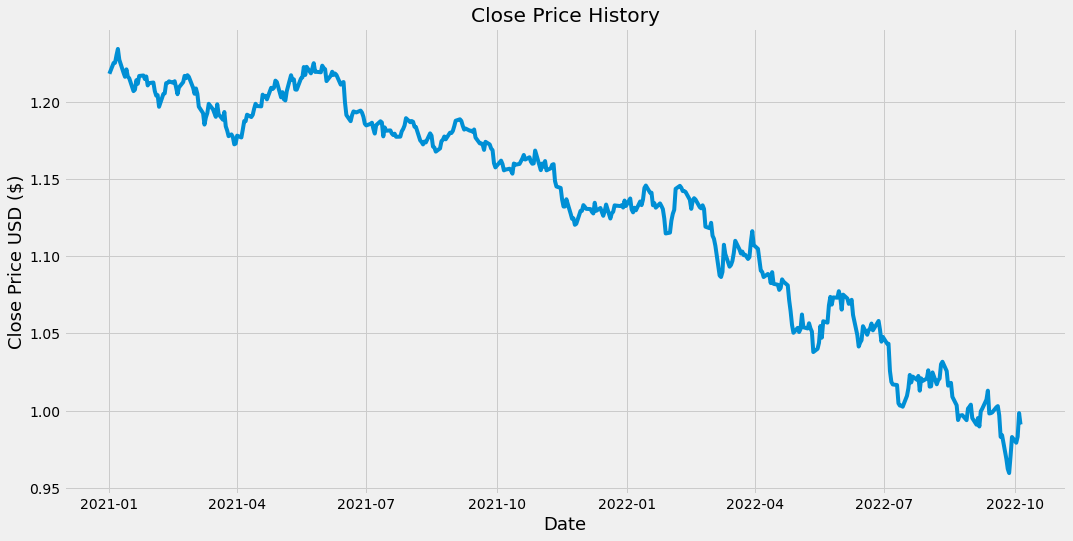

In [2]:
df = web.DataReader('EURUSD=X', data_source='yahoo', start='2021-01-01', end='2022-10-05')
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [3]:
df.shape

(460, 6)

In [4]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-01-01,1.221699,1.213499,1.217285,1.218027,0,1.218027
2021-01-04,1.230999,1.217137,1.224905,1.225070,0,1.225070
2021-01-05,1.229483,1.224995,1.225295,1.225160,0,1.225160
2021-01-06,1.235025,1.226693,1.229861,1.230027,0,1.230027
2021-01-07,1.234568,1.224665,1.233776,1.234111,0,1.234111


In [5]:
data = df.filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)


train_data = scaled_data[0:training_data_len, :]
# independent traning variables or traning features
x_train = []
# dependent traning variables or target variables 
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train= np.array(x_train), np.array(y_train)
# reshape inputs to 3D => 1-number of rows 2-number of culomns 3-number of features(Close Price)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(308, 60, 1)

In [6]:
# Build the LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [7]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

308/308 [==============================] - 7s 13ms/step - loss: 0.0099


In [8]:
test_data = scaled_data[training_data_len-60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [9]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the models predicted price values
predections = model.predict(x_test)
predections = scaler.inverse_transform(predections)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(predections - y_test)**2)
rmse

3/3 [==============================] - 1s 11ms/step


0.015543024177136629

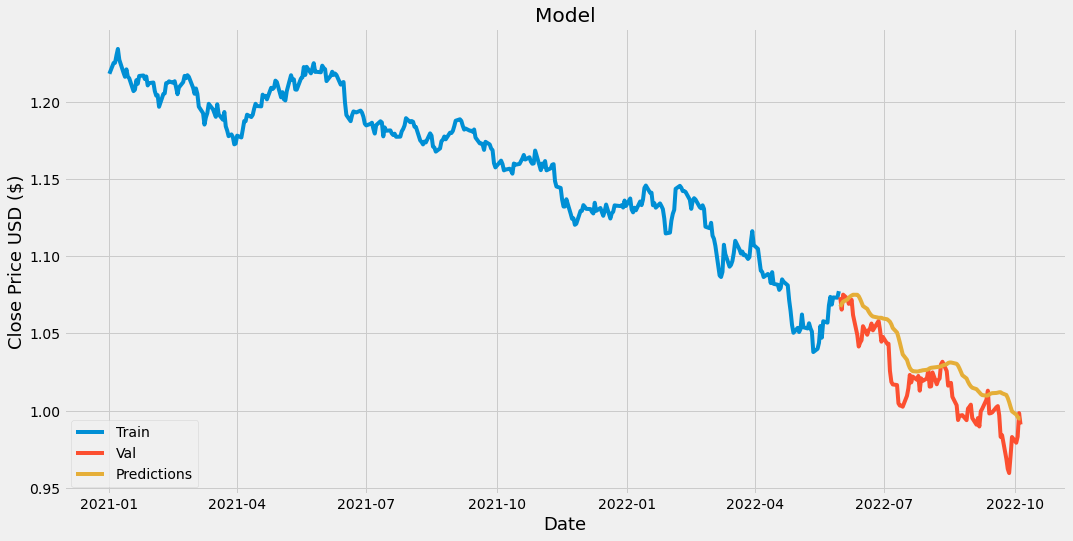

In [10]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predections
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower left')
plt.show()

In [11]:
valid

,Close,Predictions
Date,,
2022-05-31,1.073411,1.067228
2022-06-01,1.065417,1.069189
2022-06-02,1.075107,1.070580
2022-06-05,1.072605,1.071947
2022-06-06,1.069141,1.073111
...,...,...
2022-09-29,0.982956,0.999578
2022-10-02,0.979269,0.997493
2022-10-03,0.983207,0.995921


In [12]:
##### predict for next day
new_quotes = web.DataReader('EURUSD=X', data_source='yahoo', start='2022-05-05', end='2022-10-05')

new_df = new_quotes.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print("Predicted price by model is: " + str(pred_price))

1/1 [==============================] - 0s 16ms/step
Predicted price by model is: [[0.99542946]]
